**Predicting Subscription Habits based on Age and Played Hours in a Minecraft Server**

Samantha Cham, Daha Choi, Trini Laughlen, and Madeline Miles

Introduction

*Methods*

In [17]:
#load libraries needed
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#set the seed to make the process reproducible
set.seed(2025)

#read in data
players<-read_csv('https://raw.githubusercontent.com/madeline1312/toy_ds_project/refs/heads/main/players.csv')|>
mutate(subscribe=as_factor(subscribe)) #made as a factor so we can build our classification model
players

#Now we will build out model
#Let's seperate the data into training and testing data sets
players_split<-players|>
initial_split(prop=0.6, strata=subscribe)
players_train<-training(players_split)
players_test<-testing(players_split)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 22 rows.
               ✖ Assigned data has 23 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 23 to size 22.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





mean,neighbors
<dbl>,<dbl>
0.6726087,9
0.6726087,10


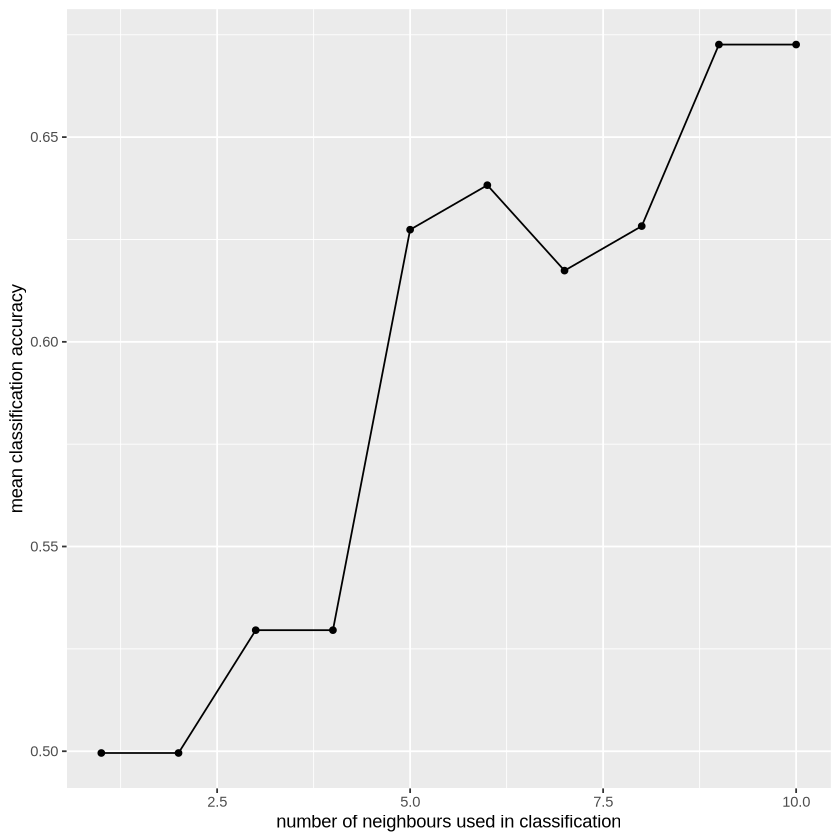

In [29]:
set.seed(2025)
#Build the model, initally use tune until the best k value is found. 
knn_tune<-nearest_neighbor(weight_func='rectangular',neighbors=tune())|>
set_engine('kknn')|>
set_mode('classification')

players_recipe<-recipe(subscribe~Age+played_hours, data=players_train)|>
step_center(all_predictors())|>
step_scale(all_predictors())

workflow<-workflow()|>
add_recipe(players_recipe)|>
add_model(knn_tune)

players_vfold<-vfold_cv(players_train, v=5, strata=subscribe)

players_table<-tibble(neighbors=seq(from=1, to=10, by=1))

knn_results<-workflow|>
tune_grid(resample=players_vfold, grid=players_table)|>
collect_metrics()|>
filter(.metric=='accuracy')

cross_val_plot<-knn_results|>
ggplot(aes(y=mean, x=neighbors))+
geom_point()+
geom_line()+
labs(y="mean classification accuracy", x="number of neighbours used in classification")
cross_val_plot

#this shows that the best neighbours for this specific model should be with k=9 or k=10, so we will check the values instead of looking at the graph

knn_value<-knn_results|>
filter(neighbors==9:10)|> select(mean, neighbors)
knn_value #The accuracy is the exact same

In [19]:
set.seed(2025)
#build the model with k=9 to have the best accuracy
players_knn<-nearest_neighbor(weight_func='rectangular', neighbors=9)|>
set_mode('classification')|>
set_engine('kknn')

players_workflow<-workflow()|>
add_recipe(players_recipe)|>
add_model(players_knn)|>
fit(data=players_train)


In [33]:
set.seed(2025)
#test the model to see if it is accurate with the testing data
knn_accuracy<-players_workflow|>
predict(players_test)|> bind_cols(players_test)|>
metrics(truth=subscribe,  estimate=.pred_class)
knn_accuracy

ERROR: [1m[33mError[39m in `bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 78) to match `..2` (size 79).


Results

Discussion